<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/DAMM_081021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
## generate data
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])
  
  x[x < 0] = 1e-4
  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])
  xx[xx < 0] = 1e-4
  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [3]:
def initialize_parameters(n_clusters, X, S, initA = "kmeans"): ## version from previous code

  n_obs, n_features = X.shape
  xx = torch.hstack((X, S.reshape(-1,1)))

  tot_clusters = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)

  if initA == "kmeans":
    kms = KMeans(tot_clusters).fit(S.reshape(-1,1))
    pred = kms.labels_
    cellsize_centers, idx = torch.sort(torch.tensor(kms.cluster_centers_.squeeze())) ## psi
    score = kms.inertia_
  else:
    gmm = GaussianMixture(tot_clusters).fit(S.reshape(-1,1))
    pred = gmm.predict(S.reshape(-1,1))
    cellsize_centers, idx = torch.sort(torch.tensor(gmm.means_.squeeze())) ## psi
    score = gmm.score(S.reshape(-1,1))

  cluster_mean = np.zeros((tot_clusters, n_features + 1)) ## mu, psi
  cluster_var = np.zeros((tot_clusters, n_features + 1)) ## sigma, omega
  topkcounts = pd.DataFrame(pred).value_counts().sort_values(ascending=False)

  weights = []
  for j in range(tot_clusters):
    weights.append(topkcounts[topkcounts.keys() == idx[j]].values[0] / n_obs)
    cluster_var[j] = np.diag(np.cov(xx[pred == int(idx[j])].T))
    cluster_mean[j] = torch.mean(xx[pred == int(idx[j])], 0)

  #print(cluster_var)
  lambda_d0 = np.sum(weights[:n_clusters])
  pi = weights[:n_clusters]

  tau = np.triu(np.ones((n_clusters, n_clusters)))
  tau[tau == 0] = float('NaN')
  tau[np.triu_indices(n_clusters)] = weights[n_clusters:]

  mu = np.log(cluster_mean[:n_clusters, :n_features])
  sigma = np.log(cluster_var[:n_clusters, :n_features]) ## multivariate normal requires cov (diag is var)
  psi = np.log(cluster_mean[:n_clusters, n_features])
  omega = np.log(cluster_var[:n_clusters, n_features] ** 0.5) ## univariate normal requires std

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  gpsi = torch.tensor(psi, requires_grad=True, dtype=torch.float, device=device)
  gomega = torch.tensor(omega, requires_grad=True, dtype=torch.float, device=device)

  gmu = torch.tensor(mu, requires_grad=True, dtype=torch.float, device=device)
  gsigma = torch.tensor(sigma, requires_grad=True, dtype=torch.float, device=device)

  return score, [torch.tensor(lambda_d0), torch.tensor(pi), torch.tensor(tau), gpsi, gomega, gmu, gsigma], [lambda_d0, pi, tau, psi, omega, mu, sigma]

In [4]:
def compute_r_v(Y, S, Theta):

  nc = len(Theta[2][1])
  no, nf = Y.shape
  
  log_lambda0_pi = torch.log(Theta[0]) + torch.log(Theta[1]) ##lambda_d0 & pi
  log_lambda1_tau = torch.log(1 - Theta[0]) + torch.log(Theta[2]) ##lambda_d1 & tau

  log_rd0z = torch.zeros(nc, no)
  log_rd1g = torch.zeros(nc, nc, no)

  cov_facts = torch.zeros(nf, 1, requires_grad=False, dtype=torch.float)

  for j in range(nc):
    
    slz = D.Normal(torch.exp(Theta[3][j]), torch.exp(Theta[4][j])).log_prob(S.float()) ## psi & omega
    elz = D.LowRankMultivariateNormal(torch.exp(Theta[5][j]), cov_facts, torch.exp(Theta[6][j])).log_prob(Y.float()) ## mu & sigma
    
    log_rd0z[j] = log_lambda0_pi[j] + elz + slz

    for k in range(nc):
      if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
        log_rd1g[j,k] = float("NaN")
      else:
        slg = D.Normal((torch.exp(Theta[3][j]) + torch.exp(Theta[3][k])), torch.exp(Theta[4][j]) + torch.exp(Theta[4][k])).log_prob(S.float())
        elg = D.LowRankMultivariateNormal((torch.exp(Theta[5][j]) + torch.exp(Theta[5][k]))/2, cov_facts, (torch.exp(Theta[6][j]) + torch.exp(Theta[6][k]))/2).log_prob(Y.float())

        log_rd1g[j,k] = log_lambda1_tau[j,k] + elg + slg

  log_rd1g = log_rd1g.reshape(nc * nc, no) #shape: (cxc')xn

  ignored_indices = torch.isnan(torch.logsumexp(log_rd1g, 1))
  assert(ignored_indices.sum() == (nc * nc - nc) / 2)
    
  log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z, log_rd1g[~ignored_indices])),0) #shape: n
  #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z, 0), torch.logsumexp(log_rd1g[~ignored_indices],0))),0)

  log_rdz = (log_rd0z - log_rdzg_norm).T #shape: nxc
  log_rdg = (log_rd1g - log_rdzg_norm).T #shape: nx(cxc')

  q1 = log_rd0z.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
  q2 = log_rd1g[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
  q = torch.tensor( (torch.sum(q1, 1) + torch.sum(q2, 1)).mean(), requires_grad=True, dtype=torch.float)

  return log_rd0z, log_rdz, log_rd1g, log_rdg, ignored_indices ##r & v

def Q(Theta, Y, S, r, v, ignored_indices):
  
  nc = len(Theta[2][1])
  no, nf = Y.shape

  log_lambda0_pi = torch.log(Theta[0]) + torch.log(Theta[1]) ##lambda_d0 & pi
  log_lambda1_tau = torch.log(1 - Theta[0]) + torch.log(Theta[2]) ##lambda_d1 & tau

  log_rd0z = torch.zeros(nc, no)
  log_rd1g = torch.zeros(nc, nc, no)

  cov_facts = torch.zeros(nf, 1, requires_grad=False, dtype=torch.float)
  for j in range(nc):
    
    slz = D.Normal(torch.exp(Theta[3][j]), torch.exp(Theta[4][j])).log_prob(S.float()) ## psi & omega
    elz = D.LowRankMultivariateNormal(torch.exp(Theta[5][j]), cov_facts, torch.exp(Theta[6][j])).log_prob(Y.float()) ## mu & sigma
    
    log_rd0z[j] = log_lambda0_pi[j] + elz + slz

    for k in range(nc):
      if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
        log_rd1g[j,k] = float("NaN")
      else:
        slg = D.Normal((torch.exp(Theta[3][j]) + torch.exp(Theta[3][k])), torch.exp(Theta[4][j]) + torch.exp(Theta[4][k])).log_prob(S.float())
        elg = D.LowRankMultivariateNormal((torch.exp(Theta[5][j]) + torch.exp(Theta[5][k]))/2, cov_facts, (torch.exp(Theta[6][j]) + torch.exp(Theta[6][k]))/2).log_prob(Y.float())

        log_rd1g[j,k] = log_lambda1_tau[j,k] + elg + slg

  log_rd1g = log_rd1g.reshape(nc * nc, no) #shape: (cxc')xn

  q1 = log_rd0z.T * r.exp() #; q1[torch.isnan(q1)] = 0.0
  q2 = log_rd1g[~ignored_indices].T * v[:,~ignored_indices].exp() #; q2[torch.isnan(q2)] = 0.0
  q = (torch.sum(q1, 1) + torch.sum(q2, 1)).mean()

  return q

def LL(Theta, rd0z, r, rd1g, v, ignored_indices):
    """
    returns L(\mathbf\Theta, \mathbf{Y}, \mathbf{s}, \mathbf{r}, \mathbf{v})
    """
    l1 = rd0z.T + r
    l2 = rd1g[~ignored_indices].T + v[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    ll = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

    return ll

In [5]:
no, nf = [10000, 2]
nc = 3

Y, S, XX, theta0, theta1 = generateData(nc, no, nf)
_, Theta, _ = initialize_parameters(nc, Y, S)

In [6]:
N_ITER_EM = 100
N_ITER_OPT = 20
lr = 0.0001
tot = 1e-4
ls = []
qs = []

In [7]:
opt = optim.Adam(Theta, lr=lr)
for i in range(N_ITER_EM):
  
  # E Step:
  with torch.no_grad():
    rd0z, r, rd1g, v, ignored_indices = compute_r_v(Y, S, Theta)
  
  # M step (i.e. maximizing Q):
  for j in range(N_ITER_OPT):
    opt.zero_grad()
    q = -Q(Theta, Y, S, r, v, ignored_indices)
    q.backward()
    opt.step()
  
    n_c = torch.sum(torch.exp(r), dim=0)
    Theta[1] = n_c / no #lambda_d0
    Theta[0] = torch.sum(Theta[1]) #pi

    n_cc = torch.sum(torch.exp(v).reshape(no, nc, nc), dim=0)
    Theta[2] = n_cc / no #tau

  # Check for convergence
  with torch.no_grad():
    ll = LL(Theta, rd0z, r, rd1g, v, ignored_indices)
    
    if i > 0 and abs(ls[-1] - ll) < tot:
      break
    
    qs.append(-q.detach())
    ls.append(ll)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
i

99

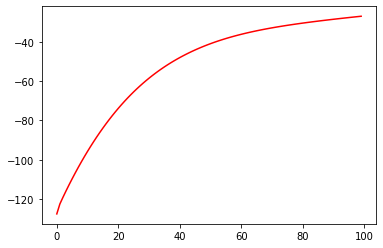

In [8]:
plt.plot(ls, 'r')

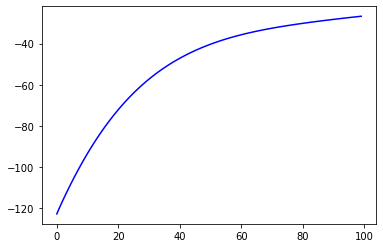

In [9]:
plt.plot(qs, 'b')

In [10]:
"""
Note: rather than deal with individual parameters constantly, we can make
Theta be a list of tensors
[mu, Sigma, psi, omega, lambda, pi, tau]
and always refer to them *within* the functions compute_v, compute_r, Q, L
when you need them, e.g.
mu = Theta[0]
etc. (this could also be a python dictionary!)
"""

'\nNote: rather than deal with individual parameters constantly, we can make\nTheta be a list of tensors\n[mu, Sigma, psi, omega, lambda, pi, tau]\nand always refer to them *within* the functions compute_v, compute_r, Q, L\nwhen you need them, e.g.\nmu = Theta[0]\netc. (this could also be a python dictionary!)\n'